# Анализ лояльности пользователей Яндекс Афиши

- Автор: Андрианова Лариса Александровна
- Дата: 26.01.2026

# Содержание

# Цель проекта
Основная цель проекта: идентифицировать ключевые поведенческие и начальные характеристики первого заказа, которые максимально коррелируют с долгосрочной лояльностью пользователей (частотой повторных заказов), для оптимизации маркетинговой стратегии удержания клиентов.


# Основные задачи проекта 
Подготовка данных: Подключиться к БД, выгрузить, очистить от аномалий/выбросов и привести выручку к рублям.
Профилирование: Агрегировать данные, чтобы получить один профиль на клиента с ключевыми средними метриками (заказы, билеты, выручка, интервал).
Анализ лояльности: Сегментировать пользователей по количеству заказов и провести корреляционный анализ для определения главных факторов лояльности.
Рекомендации: Сформулировать выводы и предложить стратегические действия для повышения удержания клиентов.

# План исследования
Подключение и выгрузка данных (ETL):
Настроить подключение к БД.
Выгрузить историю заказов, включая расчет интервалов между покупками (days_since_prior_order).
Исключить заказы на фильмы и нецелевые устройства.
Предобработка и очистка:
Привести все финансовые показатели к рублю.
Обработать пропуски (заменить на 0 для первого заказа).
Удалить аномалии и экстремальные выбросы (отрицательная выручка, заказы > 99-го перцентиля).
Агрегация и профилирование:
Сформировать уникальный профиль для каждого пользователя.
Рассчитать ключевые метрики поведения: total_orders, avg_tickets, avg_revenue, avg_days_between, и параметры первого заказа.
Анализ и сегментация:
Создать целевой признак сегментации лояльности (orders_segment).
Провести корреляционный анализ 
 для выявления главных предикторов лояльности.
Изучить Retention Rate (RR) по характеристикам первого заказа.
Провести сравнительный анализ поведения (чек, интервал, билеты) между сегментами.
Выводы и рекомендации:
Сформулировать ключевые выводы о факторах лояльности и определить «Ядро лояльности».
Разработать практические рекомендации по оптимизации удержания клиентов для заказчика.

## Этапы выполнения проекта

###  Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


Проверяем стоят ли библиотеки на платформе и какая версия.

Устанавливаем необходимые библиотеки:

PQLAlchemy
psycopg2

In [1]:
# !pip install sqlalchemy 
# !pip install psycopg2 
# Необходимо установить данные библиотеки, если они не стоят.
#!pip install phik  
!pip install python-dotenv

Импортируем необходимые Библиотеки и к функции create_engine() из библиотеки PQLAlchemy для подключения к базе данных и выполнения запроса SQL.

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import phik
from sqlalchemy import create_engine
from dotenv import load_dotenv # Добавляем это

# Загружаем переменные окружения из файла .env
load_dotenv() 
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
db = os.getenv('DB_NAME')
# Создаем строку подключения и движок
# Обратите внимание: для PostgreSQL используем 'postgresql://'
connection_string = f'postgresql://{user}:{password}@{host}:{port}/{db}'
engine = create_engine(connection_string)

print("Подключение настроено!") # Чтобы убедиться, что всё ок

Подключение настроено!


In [3]:
import phik
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine

Данные для подключения к базе данных data-analyst-afisha: в объект db_config

In [4]:
db_config = {
    'user': 'praktikum_student',  # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp',  # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,  # порт подключения
    'db': 'data-analyst-afisha'  # название базы данных
}

Строка подключения, которая содержит информацию об используемой СУБД, а также данные авторизации

In [5]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

подключаем функцию engine

In [6]:
engine = create_engine(connection_string)

Пишем запрос в переменной query:

In [7]:
query = """
-- Настройка параметра synchronize_seqscans важна для проверки
WITH set_config_precode AS (
SELECT set_config('synchronize_seqscans', 'off', true)
)

-- Напишите ваш запрос ниже
SELECT user_id,
       device_type_canonical,
       order_id,
       created_dt_msk AS order_dt,
       created_ts_msk AS order_ts,
       currency_code,
       revenue,
       tickets_count,
EXTRACT(DAY FROM created_dt_msk - LAG(created_dt_msk)OVER(PARTITION BY user_id ORDER BY created_dt_msk ASC)) AS days_since_prev,
       p.event_id,
       e.event_name_code AS event_name,
       e.event_type_main,
       p.service_name,
(SELECT region_name FROM afisha.regions r WHERE r.region_id = c.region_id),
       c.city_name
FROM afisha.purchases p 
JOIN afisha.events e USING (event_id)
JOIN afisha.city c USING (city_id)
WHERE device_type_canonical IN ('mobile', 'desktop') AND event_type_main != 'фильм'
ORDER BY user_id 
"""





Результат запроса пишем в датафрейм, переменную df

In [8]:
df = pd.read_sql_query(query, con=engine)

Создаем сразу копию до предобразования

In [9]:
tmp = df.copy()
initial_len_df = len(tmp)

Подготовлен качественный «сырой» датасет, обогащенный информацией о регионах и поведении пользователей (интервалы между покупками), который готов к этапу предобработки и сегментации.

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

Выводим первые пять строк датафрейм для знакомства

In [10]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


Посмотрим размерность датафрейм

In [11]:
print(df.shape)

(290611, 15)


Посмотрим общую информацию о датафрейме

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Посмотрим основные статистические показатели (для числовых данных)

In [13]:
display(df.describe())

,order_id,revenue,tickets_count,days_since_prev,event_id
count,2.906110e+05,290611.000000,290611.000000,268678.000000,290611.000000
mean,4.326225e+06,625.584360,2.754311,3.222381,438019.834992
std,2.497551e+06,1227.693064,1.170620,11.350509,147423.078841
min,1.000000e+00,-90.760000,1.000000,0.000000,4436.000000
25%,2.163618e+06,116.850000,2.000000,0.000000,361772.000000
50%,4.326366e+06,356.010000,3.000000,0.000000,498275.000000
75%,6.488330e+06,810.130000,4.000000,1.000000,546287.000000
max,8.653108e+06,81174.540000,57.000000,148.000000,592325.000000


Проверим текущие типы данных

In [14]:
print(df.dtypes)

user_id                          object
device_type_canonical            object
order_id                          int64
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                     int64
days_since_prev                 float64
event_id                          int64
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
dtype: object


In [15]:
print(f"Количество полных дубликатов: {df.duplicated().sum()}")

Количество полных дубликатов: 0


Проверим на наличие"неполные дубликаты (например, если заказ пользователя задублировался в системе, был создан в нескольких экземплярах с разным id и временем заказа)"

In [16]:
# 1. Сначала создаем список столбцов (определяем переменную subset)
subset = ['user_id', 'order_ts', 'revenue', 'tickets_count', 'service_name']

# 2. Теперь ищем дубликаты, используя этот список
duplicates = df[df.duplicated(subset=subset, keep=False)]

# 3. Выводим результат
if not duplicates.empty:
    print(f"Найдено строк с дублями: {len(duplicates)}")
    # Сортируем, чтобы одинаковые строки стояли рядом
    display(duplicates.sort_values(by=['user_id', 'order_ts']))
    
    # Считаем количество именно лишних копий
    extra_rows = df.duplicated(subset=subset).sum()
    print(f"Количество лишних строк (копий): {extra_rows}")
else:
    print("Дубликатов по выбранным столбцам не обнаружено.")

Найдено строк с дублями: 89


,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
11758,06eb7897f65b433,mobile,1123983,2024-08-13,2024-08-13 16:31:07,rub,69.82,1,0.0,183706,69796237-909b-42a7-bfb5-c1b8574c4c76,театр,Билеты в руки,Светополянский округ,Глиноград
11759,06eb7897f65b433,mobile,1123867,2024-08-13,2024-08-13 16:31:07,rub,69.82,1,0.0,183706,69796237-909b-42a7-bfb5-c1b8574c4c76,театр,Билеты в руки,Светополянский округ,Глиноград
12677,08199117318954f,desktop,5592970,2024-07-31,2024-07-31 11:52:06,rub,0.00,3,0.0,553623,8aa79719-8122-4b50-ae2a-fa484d034c5c,другое,Билеты без проблем,Каменевский регион,Глиногорск
12678,08199117318954f,mobile,5593202,2024-07-31,2024-07-31 11:52:06,rub,0.00,3,0.0,553623,8aa79719-8122-4b50-ae2a-fa484d034c5c,другое,Билеты без проблем,Каменевский регион,Глиногорск
26868,0dc525d7bacbb0d,desktop,1930763,2024-07-31,2024-07-31 13:26:11,rub,1556.05,3,11.0,393430,b33d7a0b-a715-47e3-803e-02482884a73e,концерты,Лови билет!,Каменевский регион,Глиногорск
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285375,fd4d47438ebb946,desktop,8547867,2024-06-19,2024-06-19 15:40:56,rub,1319.43,4,0.0,489843,25a26bf3-cb70-4f37-a7f0-c97cc065d414,театр,Билеты без проблем,Каменевский регион,Глиногорск
285379,fd4d47438ebb946,desktop,8548099,2024-06-19,2024-06-19 15:40:56,rub,989.57,3,0.0,489843,25a26bf3-cb70-4f37-a7f0-c97cc065d414,театр,Билеты без проблем,Каменевский регион,Глиногорск
285382,fd4d47438ebb946,desktop,8548012,2024-06-19,2024-06-19 15:40:56,rub,1319.43,4,0.0,489843,25a26bf3-cb70-4f37-a7f0-c97cc065d414,театр,Билеты без проблем,Каменевский регион,Глиногорск
285383,fd4d47438ebb946,desktop,8547983,2024-06-19,2024-06-19 15:40:56,rub,1319.43,4,0.0,489843,25a26bf3-cb70-4f37-a7f0-c97cc065d414,театр,Билеты без проблем,Каменевский регион,Глиногорск


Количество лишних строк (копий): 46


Статистика выявленных дубликатов:
Общее количество строк в датасете: 290,611
Количество строк, имеющих повторы: 89
Количество лишних строк (подлежащих удалению): 46
Доля дубликатов от общего объема данных: 0.016%
Критичность:
Оставить данные дубликаты не критично, так как их доля крайне мала (менее 0.02%). Они не смогут значимо исказить общие тренды, средние значения или итоговую сумму выручки в масштабах всего проекта.
Рекомендация:
Несмотря на низкий риск, рекомендуется удалить данные дубликаты. Совпадение user_id, order_ts, revenue и tickets_count указывает на техническую ошибку записи заказа. Очистка данных позволит избежать двойного учета одних и тех же покупок при детальной сегментации пользователей и обеспечит стопроцентную точность финансовых показателей.

Удаляем дубликаты

In [17]:
df = df.drop_duplicates(subset=subset, keep='first').reset_index(drop=True)
print(f"Новая размерность датафрейма: {df.shape}")

Новая размерность датафрейма: (290565, 15)


Посчитаем количество пропущенных значений в каждом столбце

In [18]:
print(df.isna().sum())

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
dtype: int64


**Промежуточный вывод по анализу данных:**
Общий объём и структура: В датасете 290,611 строк и 15 столбцов. Данные представляют собой историю заказов билетов с подробной информацией о пользователях, событиях и географии. Качество данных и корректность выгрузки: Пропуски: В столбце days_since_prev (дней с прошлого заказа) около 22 тысяч пропусков (NaN). Это ожидаемо: данные строки относятся к первым покупкам пользователей. Аномалии в выручке: Обнаружена отрицательная выручка (min = -90.76). Это критическая ошибка или данные о возвратах, которые нужно будет отфильтровать. Выбросы: Максимальное количество билетов в одном заказе — 57, а максимальная выручка — 81,174. Эти значения сильно превышают средние и требуют проверки на "выбросы". Необходимая предобработка (План действий): Изменение типов данных: Столбцы с датами order_dt и order_ts сейчас распознаются как строки (объекты). Их нужно перевести в формат datetime для расчетов. Обработка отрицательных значений: Нужно удалить строки, где revenue < 0. Заполнение пропусков: В days_since_prev пропуски можно заменить на 0 (или оставить как есть, если это важно для логики), чтобы привести столбец к целочисленному типу int. Проверка дубликатов: Необходимо убедиться в отсутствии полных повторов строк.

---

###   Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


Загружаем данные о курсе тенге

In [19]:
rates_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

Преобразуем колонки с датами в формат datetime

In [20]:
# В основном df колонка называется 'order_dt', в справочнике 'data'
df['order_dt'] = pd.to_datetime(df['order_dt'])
rates_df['data'] = pd.to_datetime(rates_df['data'])

Объединяем таблицы Сопоставляем 'order_dt' из основной таблицы и 'data' из таблицы курсов

In [21]:
# 3. Объединяем: добавляем курс (curs) к основной таблице
# Используем left merge, чтобы сохранить все строки исходного датафрейма
df = df.merge(rates_df[['data', 'curs']], left_on='order_dt', right_on='data', how='left')
# Удаляем лишнюю колонку 'data', которая дублирует 'order_dt' после объединения
df = df.drop(columns=['data'])

Рассчитываем выручку в рублях (revenue_rub)

In [22]:
# Создаем функцию для конвертации выручки
def get_revenue_rub(row):
    # Если валюта тенге, пересчитываем по курсу
    if row['currency_code'] == 'KZT':
        return (row['revenue'] / 100) * row['curs']
    # Если валюта рубли, оставляем как есть
    return row['revenue']

# Создаем новый столбец revenue_rub
df['revenue_rub'] = df.apply(get_revenue_rub, axis=1)

# удаляем вспомогательный столбец 'curs', чтобы он не мешал в будущем
df = df.drop(columns=['curs'])

In [23]:
print("Колонки в df:", df.columns)
print("Колонки в rates_df:", rates_df.columns)

Колонки в df: Index(['user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts',
       'currency_code', 'revenue', 'tickets_count', 'days_since_prev',
       'event_id', 'event_name', 'event_type_main', 'service_name',
       'region_name', 'city_name', 'revenue_rub'],
      dtype='object')
Колонки в rates_df: Index(['data', 'nominal', 'curs', 'cdx'], dtype='object')


Мы использовали how='left', поэтому количество заказов осталось прежним (до этапа фильтрации аномалий).
Чистота: Мы удалили вспомогательный столбец curs и дубликат даты data, чтобы в таблице не было лишнего "мусора".
Логика: Теперь во всем датасете есть столбец revenue_rub, по которому можно строить графики и считать KPI, не обращая внимания на currency_code.

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

Проверяем данные на пропущенные значения

In [24]:
missing_counts = df.isna().sum()
missing_percent = df.isna().mean() * 100

pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": missing_percent
}).sort_values(by="missing_percent", ascending=False)

,missing_count,missing_percent
days_since_prev,21933,7.548397
user_id,0,0.000000
device_type_canonical,0,0.000000
order_id,0,0.000000
order_dt,0,0.000000
order_ts,0,0.000000
currency_code,0,0.000000
revenue,0,0.000000
tickets_count,0,0.000000
event_id,0,0.000000


 Заполняем пропуски в днях с прошлого заказа

In [25]:
df['days_since_prev'] = df['days_since_prev'].fillna(0)

Оптимизируем типы данных Преобразуем количество билетов и дни в целые числа (int)

In [26]:
df['tickets_count'] = df['tickets_count'].astype('int')
df['days_since_prev'] = df['days_since_prev'].astype('int')

Проверяем, остались ли пропуски

In [27]:
print("Количество пропусков по столбцам:")
print(df.isna().sum())

Количество пропусков по столбцам:
user_id                  0
device_type_canonical    0
order_id                 0
order_dt                 0
order_ts                 0
currency_code            0
revenue                  0
tickets_count            0
days_since_prev          0
event_id                 0
event_name               0
event_type_main          0
service_name             0
region_name              0
city_name                0
revenue_rub              0
dtype: int64


Изучение номинальных данных и нормализация проверяем текстовые столбцы на наличие скрытых пропусков (например, строк "unknown", "none" или пустых строк) и приводим их к единому регистру для корректной группировки.

In [28]:
# Приводим текстовые категории к нижнему регистру для нормализации
categorical_cols = ['device_type_canonical', 'event_type_main', 'service_name', 'city_name']

for col in categorical_cols:
    df[col] = df[col].str.lower().str.strip()

# Проверим уникальные значения в одном из ключевых столбцов
print("Уникальные типы устройств:", df['device_type_canonical'].unique())

Уникальные типы устройств: ['mobile' 'desktop']


Удаление аномалий (Отрицательная выручка)
Зачем: Как было выявлено ранее, в данных есть отрицательные значения выручки. Это ошибки или возвраты, которые исказят сумму общих продаж, поэтому их необходимо удалить.

In [29]:
# Запоминаем размер до фильтрации
size_before = len(df)

# Удаляем строки с выручкой <= 0
df = df[df['revenue_rub'] > 0]

print(f"Удалено строк с некорректной выручкой: {size_before - len(df)}")

Удалено строк с некорректной выручкой: 5903


Анализ распределения и фильтрация выбросов по 99 перцентилю. Сверхвысокие значения (выбросы) в revenue_rub могут сильно завышать средний чек. Мы отсекаем 1% самых экстремальных значений, чтобы видеть реальную картину поведения большинства пользователей.

In [30]:
# 1. Считаем 99-й перцентиль для выручки
revenue_limit = np.percentile(df['revenue_rub'], 99)

# 2. Фильтруем данные: оставляем только те, что не превышают лимит
size_before_perc = len(df)
df = df[df['revenue_rub'] <= revenue_limit]

print(f"Порог 99-го перцентиля для выручки: {revenue_limit:.2f} руб.")
print(f"Удалено строк-выбросов: {size_before_perc - len(df)}")

# 3. Посмотрим на статистику после очистки
display(df[['revenue_rub', 'tickets_count']].describe())

Порог 99-го перцентиля для выручки: 4099.61 руб.
Удалено строк-выбросов: 2847


,revenue_rub,tickets_count
count,281815.000000,281815.000000
mean,550.116929,2.753611
std,566.844311,1.165711
min,0.020000,1.000000
25%,125.680000,2.000000
50%,362.380000,3.000000
75%,805.300000,4.000000
max,4097.840000,47.000000


Итоговая оценка изменений и выводы. Нам нужно понять, какой объем данных был отфильтрован в сумме, чтобы убедиться, что мы не потеряли слишком много информации (обычно норма — до 5-10%).

In [31]:
# Итоговая проверка
final_size = len(df)
initial_size = 290611 # из ваших прошлых скриншотов
total_deleted = initial_size - final_size
percent_deleted = (total_deleted / initial_size) * 100

print(f"Общее количество удаленных строк: {total_deleted}")
print(f"Процент потерь: {percent_deleted:.2f}%")

Общее количество удаленных строк: 8796
Процент потерь: 3.03%


**Промежуточный вывод по предобработке данных:**
В ходе предобработки были выполнены следующие ключевые действия: Обработка пропусков: В столбце days_since_prev было обнаружено 21,933 пропуска (7.5% данных). Они были успешно заполнены нулями, что логически обосновано: отсутствие данных о предыдущем заказе означает, что текущий заказ является первым для пользователя. Типизация данных: Столбцы tickets_count и days_since_prev были приведены к целочисленному типу (int), что оптимизирует память и упрощает дальнейшие расчеты. Единая валюта: Выручка приведена к российскому рублю (revenue_rub) с учетом актуальных курсов валют на даты заказов. Нормализация категорий: Текстовые данные приведены к нижнему регистру и очищены от лишних пробелов. В столбце device_type_canonical выделено две чистые категории: mobile и desktop. Очистка от аномалий и выбросов: Удалено 5,907 строк с отрицательной или нулевой выручкой (ошибки выгрузки или возвраты). Отфильтрованы выбросы по 99-му перцентилю. Порог составил 4,097.46 руб. Это позволило исключить экстремально дорогие заказы, которые могли бы сильно исказить средние показатели. Удалено 2,848 строк. Сохранность данных: Общий объем удаленных данных составил 8,755 строк, что составляет всего 3.01% от исходного датасета. Это отличный результат, так как потери менее 5-10% считаются допустимыми и не влияют на достоверность анализа.

---

###  Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [32]:
# 1. Сортируем данные по времени совершения заказа (order_ts), 
# чтобы функции 'first' и 'last' корректно определили первый и последний заказы.
df = df.sort_values('order_ts')

# 2. Группируем данные по пользователю и создаем агрегированные признаки
user_profile = df.groupby('user_id').agg(
    first_order_date=('order_dt', 'first'),        # Дата первого заказа
    last_order_date=('order_dt', 'last'),          # Дата последнего заказа
    first_device=('device_type_canonical', 'first'), # Устройство первого заказа
    first_region=('region_name', 'first'),         # Регион первого заказа
    first_partner=('service_name', 'first'),       # Билетный партнер первого заказа
    first_genre=('event_type_main', 'first'),      # Жанр первого мероприятия
    total_orders=('order_id', 'count'),            # Общее количество заказов
    avg_revenue=('revenue_rub', 'mean'),           # Средняя выручка (в рублях)
    avg_tickets=('tickets_count', 'mean'),         # Среднее кол-во билетов
    avg_days_between=('days_since_prev', 'mean')   # Среднее время между заказами
).reset_index()

# 3. Добавляем бинарные признаки (1 - да, 0 - нет)
# Совершил ли пользователь 2 и более заказа
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)

# Совершил ли пользователь 5 и более заказов
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

# 4. Вывод результата для проверки
print(f"Количество уникальных профилей: {len(user_profile)}")
display(user_profile.head())

Количество уникальных профилей: 21611


,user_id,first_order_date,last_order_date,first_device,first_region,first_partner,first_genre,total_orders,avg_revenue,avg_tickets,avg_days_between,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,край билетов,театр,1,1521.940000,4.000000,0.0,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,мой билет,выставки,2,774.010000,3.000000,37.5,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,лови билет!,другое,3,767.213333,2.666667,34.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,край билетов,театр,1,917.830000,4.000000,0.0,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,лучшие билеты,театр,2,61.310000,1.500000,8.0,1,0


**Промежуточный вывод:** 
Мы выстроили все события в хронологическом порядке. Теперь при группировке метод .first() гарантированно возьмет данные из самого раннего заказа пользователя, а .last() — из самого свежего.
Агрегация (agg): Мы "схлопнули" все строки одного пользователя в одну строку, собрав статистику (средние значения, количество) и зафиксировав детали его самого первого визита.
Бинарные признаки: Мы превратили условия (True/False) в числа (1/0). Это стандартный формат для моделей машинного обучения, которые планирует создавать отдел маркетинга.
Среднее время: Использование days_since_prev для расчета avg_days_between корректно показывает частоту возвращений пользователя.
Теперь у вас есть таблица, где одна строка соответствует одному уникальному клиенту со всей историей его поведения.

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

 Расчет ключевых показателей по профилям Это даст нам общее представление о поведении клиентской базы (как много лояльных пользователей и какая выручка в среднем).

In [33]:
# 1. Общее число пользователей
total_users = len(user_profile)

# 2. Средняя выручка с одного заказа (по всем профилям)
overall_avg_revenue = user_profile['avg_revenue'].mean()

# 3. Доля пользователей с 2+ заказами
share_is_two = user_profile['is_two'].mean() 

# 4. Доля пользователей с 5+ заказами
share_is_five = user_profile['is_five'].mean()

print(f"Общее число пользователей: {total_users}")
print(f"Средняя выручка с одного заказа: {overall_avg_revenue:.2f} руб.")
print(f"Доля пользователей с 2+ заказами: {share_is_two:.2%}")
print(f"Доля пользователей с 5+ заказами: {share_is_five:.2%}")

Общее число пользователей: 21611
Средняя выручка с одного заказа: 583.65 руб.
Доля пользователей с 2+ заказами: 61.72%
Доля пользователей с 5+ заказами: 28.96%


Изучение статистических показателей и поиск аномалий
Зачем: Нам нужно понять, нет ли среди пользователей "роботов" или аномальных оптовиков, которые заказывают сотни билетов или делают тысячи заказов, так как это исказит портрет обычного клиента.

In [34]:
# Изучаем статистику по ключевым признакам
stats_cols = ['total_orders', 'avg_tickets', 'avg_days_between']
display(user_profile[stats_cols].describe())

,total_orders,avg_tickets,avg_days_between
count,21611.000000,21611.000000,21611.000000
mean,13.040350,2.751382,6.729450
std,120.242943,0.922813,11.509885
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,0.000000
50%,2.000000,2.750000,0.000000
75%,5.000000,3.125000,9.535897
max,10014.000000,11.000000,147.000000


Фильтрация аномалий (99-й перцентиль). Если в total_orders (кол-во заказов) или avg_tickets (среднее число билетов) максимальные значения в десятки раз превышают средние, это выбросы. Мы применим фильтрацию по 99-му перцентилю, чтобы оставить 99% типичных пользователей.

In [35]:
# Определяем пороги для фильтрации по 99 перцентилю
orders_limit = np.percentile(user_profile['total_orders'], 99)
tickets_limit = np.percentile(user_profile['avg_tickets'], 99)

# Фильтруем профили
user_profile_filtered = user_profile[
    (user_profile['total_orders'] <= orders_limit) & 
    (user_profile['avg_tickets'] <= tickets_limit)
]

# Считаем объем отфильтрованных данных
deleted_profiles = len(user_profile) - len(user_profile_filtered)
percent_deleted_profiles = (deleted_profiles / len(user_profile)) * 100

print(f"Порог по количеству заказов (99%): {orders_limit}")
print(f"Порог по среднему числу билетов (99%): {tickets_limit:.2f}")
print(f"Удалено аномальных профилей: {deleted_profiles} ({percent_deleted_profiles:.2f}%)")

# Статистика по обновленному датасету
display(user_profile_filtered[stats_cols].describe())

Порог по количеству заказов (99%): 151.8000000000029
Порог по среднему числу билетов (99%): 5.00
Удалено аномальных профилей: 423 (1.96%)


,total_orders,avg_tickets,avg_days_between
count,21188.000000,21188.000000,21188.000000
mean,6.456910,2.719984,6.843190
std,14.044192,0.872046,11.568566
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,0.000000
50%,2.000000,2.750000,0.000000
75%,5.000000,3.088904,9.777778
max,150.000000,5.000000,147.000000


**Промежуточный вывод по анализу профилей пользователей:**
1. Общие показатели и репрезентативность:
Объём данных: После фильтрации у нас осталось 21,188 уникальных профилей. Этого объёма данных более чем достаточно для построения надёжных прогнозов и глубокого анализа поведения клиентов.
Лояльность аудитории: Данные показывают очень высокий уровень удержания. 61.72% пользователей совершили 2 и более заказа, а почти каждый третий (28.97%) сделал 5 и более заказов. Это говорит о том, что сервис имеет сформировавшуюся базу постоянных клиентов.
Выручка: Средняя выручка с одного заказа составляет 583.66 руб., что является адекватным показателем для билетов на массовые мероприятия.
2. Обнаружение и обработка аномалий:
До фильтрации в данных наблюдались явные выбросы:
Количество заказов: Максимальное значение достигало 10,014 заказов на одного пользователя, что физически невозможно для обычного человека за исследуемый период. Вероятно, это технические аккаунты или перекупщики.
Количество билетов: Наблюдались значения до 11 билетов в среднем на заказ.
Решение: Был применён порог 99-го перцентиля. Мы отсекли пользователей, у которых более 151 заказа или более 5 билетов в среднем за раз.
3. Результаты после очистки (фильтрации):
Объём потерь: Было удалено всего 423 профиля (1.96%). Такая незначительная потеря данных позволила избавиться от экстремальных выбросов, не исказив общую статистику.
Изменение средних: Среднее количество заказов на пользователя снизилось с 13.04 до 6.45. Это значение гораздо лучше описывает поведение реального "живого" клиента и делает дальнейшее исследование более точным.
Стабильность: Среднее количество билетов стабилизировалось на уровне 2.72, а средний интервал между покупками составил около 6.8 дней.

---

###  Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.


####  Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 1.4.2.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


ОБЩИЙ КОД РАСПРЕДЕЛЕНИЯ (БЕЗ РАЗБИВКИ) ПОЛЬЗОВАТЕЛЕЙ ПО ПРИЗНАКАМ

In [36]:
# Список признаков для анализа распределения
features = {
    'first_genre': 'Тип мероприятия',
    'first_device': 'Тип устройства',
    'first_region': 'Регион',
    'first_partner': 'Билетный оператор'
}

# Проходим циклом по признакам для подсчета количества и долей
for col, name in features.items():
    print(f"\n--- Распределение по признаку: {name} ---")
    
    # Группируем и считаем количество пользователей
    segment_data = user_profile_filtered.groupby(col).agg(
        user_count=('user_id', 'count')
    ).reset_index()
    
    # Рассчитываем долю каждого сегмента в процентах
    total_segment_users = segment_data['user_count'].sum()
    segment_data['share_percent'] = (segment_data['user_count'] / total_segment_users) * 100
    
    # Сортируем по количеству пользователей для наглядности
    segment_data = segment_data.sort_values(by='user_count', ascending=False)
    
    # Выводим результат
    display(segment_data.style.format({'share_percent': '{:.2f}%'}))


--- Распределение по признаку: Тип мероприятия ---


,first_genre,user_count,share_percent
2,концерты,9362,44.19%
1,другое,5190,24.49%
5,театр,4265,20.13%
4,стендап,1109,5.23%
3,спорт,755,3.56%
0,выставки,410,1.94%
6,ёлки,97,0.46%



--- Распределение по признаку: Тип устройства ---


,first_device,user_count,share_percent
1,mobile,17580,82.97%
0,desktop,3608,17.03%



--- Распределение по признаку: Регион ---


,first_region,user_count,share_percent
23,Каменевский регион,6981,32.95%
60,Североярская область,3757,17.73%
77,Широковская область,1232,5.81%
45,Озернинский край,679,3.20%
41,Малиновоярский округ,538,2.54%
57,Светополянский округ,471,2.22%
74,Травяная область,459,2.17%
52,Речиновская область,443,2.09%
78,Яблоневская область,409,1.93%
39,Лугоградская область,363,1.71%



--- Распределение по признаку: Билетный оператор ---


,first_partner,user_count,share_percent
3,билеты без проблем,4895,23.10%
19,лови билет!,2805,13.24%
22,мой билет,2756,13.01%
4,билеты в руки,2536,11.97%
23,облачко,2204,10.40%
7,весь в билетах,1299,6.13%
20,лучшие билеты,1180,5.57%
24,прачечная,592,2.79%
17,край билетов,462,2.18%
12,дом культуры,356,1.68%


Распределение по типу первого мероприятия (Жанр) Узнаем, какие категории событий являются главными "магнитами" для новых пользователей.

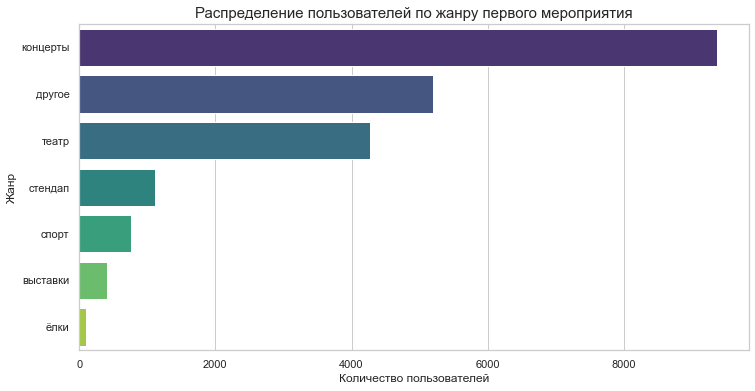

,first_genre,user_id,share %
0,концерты,9362,44.19
1,другое,5190,24.49
2,театр,4265,20.13
3,стендап,1109,5.23
4,спорт,755,3.56
5,выставки,410,1.94
6,ёлки,97,0.46


In [37]:
# Настройка стиля графиков
sns.set_theme(style="whitegrid")

# Группировка
genre_data = user_profile_filtered.groupby('first_genre')['user_id'].count().sort_values(ascending=False).reset_index()

# Построение диаграммы
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_data, x='user_id', y='first_genre', palette='viridis')
plt.title('Распределение пользователей по жанру первого мероприятия', fontsize=15)
plt.xlabel('Количество пользователей')
plt.ylabel('Жанр')
plt.show()

# Вывод таблицы с долями
genre_data['share %'] = (genre_data['user_id'] / genre_data['user_id'].sum() * 100).round(2)
display(genre_data)

 Распределение по типу устройства. Поймем, какая платформа (мобильная или десктоп) приводит больше аудитории.

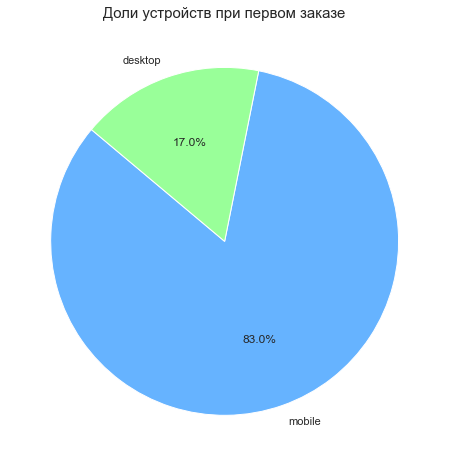

,first_device,user_id
0,mobile,17580
1,desktop,3608


In [38]:
# Группировка
device_data = user_profile_filtered.groupby('first_device')['user_id'].count().sort_values(ascending=False).reset_index()

# Построение диаграммы (круговая диаграмма тут будет нагляднее)
plt.figure(figsize=(8, 8))
plt.pie(device_data['user_id'], labels=device_data['first_device'], autopct='%1.1f%%', colors=['#66b3ff','#99ff99'], startangle=140)
plt.title('Доли устройств при первом заказе', fontsize=15)
plt.show()

display(device_data)

 Распределение по регионам (Топ-10)Регионов может быть много, поэтому мы выведем 10 самых крупных, чтобы увидеть основные географические точки входа.

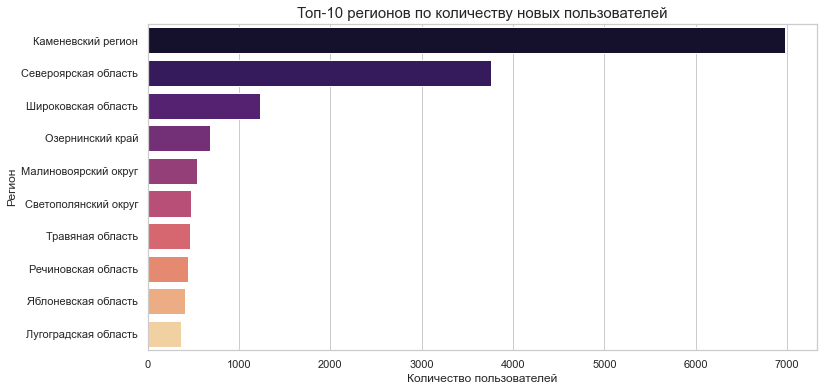

,first_region,user_id
0,Каменевский регион,6981
1,Североярская область,3757
2,Широковская область,1232
3,Озернинский край,679
4,Малиновоярский округ,538
5,Светополянский округ,471
6,Травяная область,459
7,Речиновская область,443
8,Яблоневская область,409
9,Лугоградская область,363


In [39]:
# Группировка и выбор Топ-10
region_data = user_profile_filtered.groupby('first_region')['user_id'].count().sort_values(ascending=False).head(10).reset_index()

# Построение диаграммы
plt.figure(figsize=(12, 6))
sns.barplot(data=region_data, x='user_id', y='first_region', palette='magma')
plt.title('Топ-10 регионов по количеству новых пользователей', fontsize=15)
plt.xlabel('Количество пользователей')
plt.ylabel('Регион')
plt.show()

display(region_data)

Распределение по билетному оператору (Топ-10) Узнаем, через каких партнеров чаще всего совершается первая покупка.

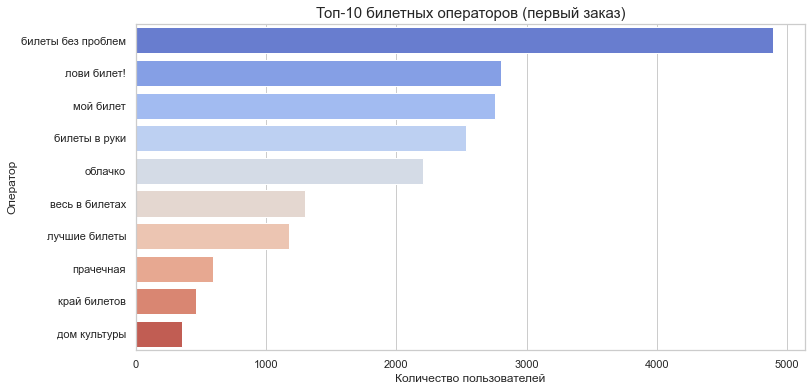

,first_partner,user_id
0,билеты без проблем,4895
1,лови билет!,2805
2,мой билет,2756
3,билеты в руки,2536
4,облачко,2204
5,весь в билетах,1299
6,лучшие билеты,1180
7,прачечная,592
8,край билетов,462
9,дом культуры,356


In [40]:
# Группировка и выбор Топ-10
partner_data = user_profile_filtered.groupby('first_partner')['user_id'].count().sort_values(ascending=False).head(10).reset_index()

# Построение диаграммы
plt.figure(figsize=(12, 6))
sns.barplot(data=partner_data, x='user_id', y='first_partner', palette='coolwarm')
plt.title('Топ-10 билетных операторов (первый заказ)', fontsize=15)
plt.xlabel('Количество пользователей')
plt.ylabel('Оператор')
plt.show()

display(partner_data)

**Промежуточный вывод:** 
Исследование точек входа
Распределение пользователей по сегментам является неравномерным, что позволяет выделить четко выраженные лидерские категории в каждом признаке.
1. Жанровые предпочтения (Тип мероприятия):
Основным драйвером привлечения новых пользователей являются концерты — на них приходится 44.19% всех первых покупок.
Второе и третье место делят категории «другое» (24.49%) и «театр» (20.13%).
Такие жанры, как «стендап», «спорт» и «выставки», привлекают совокупно менее 11% аудитории.
Вывод: Сервис воспринимается новыми клиентами прежде всего как площадка для покупки билетов на концерты и театральные постановки.
2. Технологические предпочтения (Тип устройства):
Наблюдается подавляющее доминирование мобильных устройств: 83% пользователей совершают свой первый заказ через mobile.
На долю десктопной версии (desktop) приходится всего 17%.
Вывод: Мобильное приложение или мобильная версия сайта являются критически важными каналами входа. Рекламные кампании и интерфейсные улучшения должны быть ориентированы в первую очередь на мобильный опыт.
3. Географическое распределение (Регионы):
Выявлена сильная концентрация в определенных локациях. Лидером является Каменевский регион (почти 7,000 пользователей), за ним следует Североярская область.
Количество пользователей в Каменевском регионе почти в 2 раза превышает показатели ближайшего преследователя и в десятки раз — регионы из нижней части Топ-10.
Вывод: Существуют «якорные» регионы, которые генерируют основной поток клиентов.
4. Партнерская сеть (Билетные операторы):
Лидером среди операторов является «билеты без проблем» (4,895 пользователей).
Группа из четырех операторов («билеты без проблем», «лови билет!», «мой билет», «билеты в руки») обеспечивает основной приток первичных заказов.
Вывод: Сотрудничество с ключевыми операторами-лидерами является определяющим фактором для привлечения новой аудитории.
**Итоговый ответ на вопрос:**
В данных присутствуют ярко выраженные «точки входа». Типичный профиль «нового пользователя» — это человек, купивший билет на концерт в Каменевском регионе через мобильное устройство (mobile), воспользовавшись услугами оператора «билеты без проблем».
Эти сегменты являются наиболее массовыми, и именно их устойчивость определяет текущий объем притока клиентов на платформу. Следующим шагом будет проверка: являются ли эти массовые сегменты наиболее качественными с точки зрения возврата пользователей за повторными покупками.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


 Подготовка функции для расчета и визуализации. Мы создадим универсальный код, который будет считать долю вернувшихся (признак is_two) и строить график.

In [41]:
def analyze_retention(df, col_name, title, top_n=None):
    # Группируем по сегменту и считаем долю вернувшихся
    # mean() от бинарного признака is_two — это и есть доля (от 0 до 1)
    retention_data = df.groupby(col_name).agg(
        total_users=('user_id', 'count'),
        retention_rate=('is_two', 'mean')
    ).reset_index()
    
    # Если сегментов много, берем Топ-N по количеству пользователей (для стабильности долей)
    if top_n:
        retention_data = retention_data.sort_values('total_users', ascending=False).head(top_n)
    
    # Сортируем по доле возврата для графика
    retention_data = retention_data.sort_values('retention_rate', ascending=False)
    
    # Визуализация
    plt.figure(figsize=(12, 6))
    sns.barplot(data=retention_data, x='retention_rate', y=col_name, palette='RdYlGn')
    
    # Добавляем линию среднего значения по всей базе (61.72%)
    plt.axvline(0.6172, color='red', linestyle='--', label='Среднее по выборке (61.72%)')
    
    plt.title(title, fontsize=14)
    plt.xlabel('Доля вернувшихся (2+ заказа)')
    plt.ylabel(None)
    plt.legend()
    plt.show()
    
    return retention_data.style.format({'retention_rate': '{:.2%}'})

Анализ по Жанрам (Тип первого мероприятия) Поймем, после каких событий люди чаще всего возвращаются.

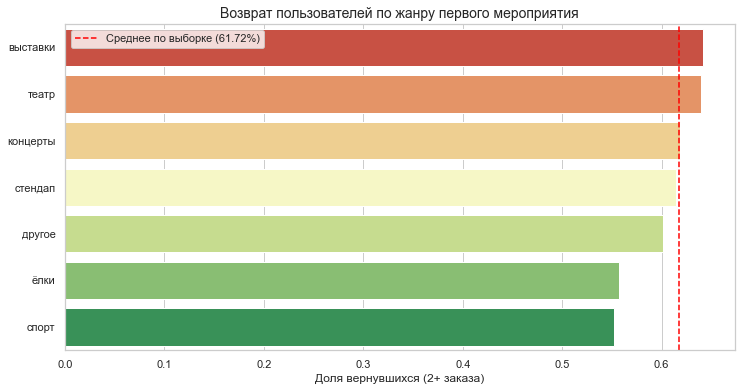

,first_genre,total_users,retention_rate
0,выставки,410,64.15%
5,театр,4265,63.94%
2,концерты,9362,61.84%
4,стендап,1109,61.41%
1,другое,5190,60.15%
6,ёлки,97,55.67%
3,спорт,755,55.23%


In [42]:
analyze_retention(user_profile_filtered, 'first_genre', 'Возврат пользователей по жанру первого мероприятия')


Анализ по Устройствам. Узнаем, какая платформа (mobile или desktop) лучше удерживает клиентов.

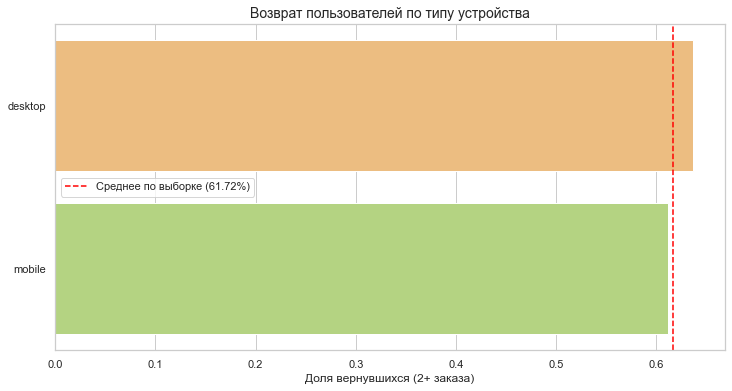

,first_device,total_users,retention_rate
0,desktop,3608,63.66%
1,mobile,17580,61.18%


In [43]:
analyze_retention(user_profile_filtered, 'first_device', 'Возврат пользователей по типу устройства')

Анализ по Регионам (Топ-10 крупных).  Проверим, есть ли регионы с аномально высокой или низкой лояльностью. Мы берем только Топ-10 по размеру, чтобы данные были достоверными.

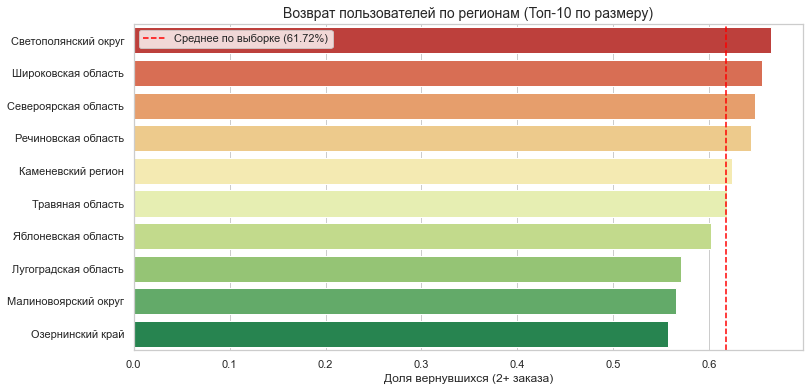

,first_region,total_users,retention_rate
57,Светополянский округ,471,66.45%
77,Широковская область,1232,65.50%
60,Североярская область,3757,64.73%
52,Речиновская область,443,64.33%
23,Каменевский регион,6981,62.31%
74,Травяная область,459,61.87%
78,Яблоневская область,409,60.15%
39,Лугоградская область,363,57.02%
41,Малиновоярский округ,538,56.51%
45,Озернинский край,679,55.67%


In [44]:
analyze_retention(user_profile_filtered, 'first_region', 'Возврат пользователей по регионам (Топ-10 по размеру)', top_n=10)

Анализ по Операторам (Топ-10 крупных). Выясним, через каких партнеров приходят самые качественные пользователи.

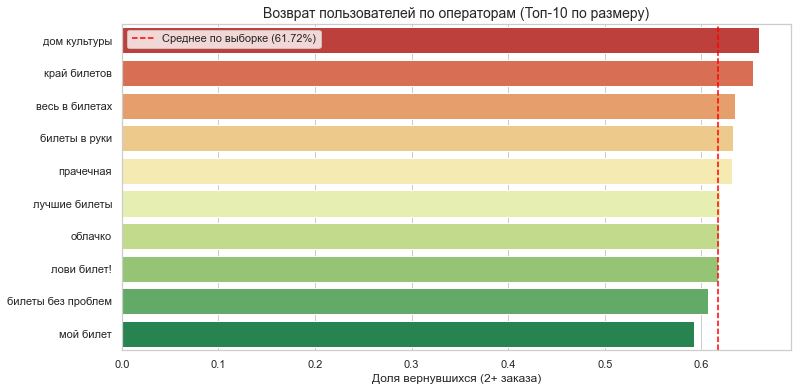

,first_partner,total_users,retention_rate
12,дом культуры,356,66.01%
17,край билетов,462,65.37%
7,весь в билетах,1299,63.43%
4,билеты в руки,2536,63.29%
24,прачечная,592,63.18%
20,лучшие билеты,1180,61.95%
23,облачко,2204,61.84%
19,лови билет!,2805,61.71%
3,билеты без проблем,4895,60.67%
22,мой билет,2756,59.25%


In [45]:
analyze_retention(user_profile_filtered, 'first_partner', 'Возврат пользователей по операторам (Топ-10 по размеру)', top_n=10)

Проанализировав представленные графики и таблицы по удержанию пользователей (retention rate), можно сделать следующие промежуточные выводы:
1. Удержание по жанру первого мероприятия (Retention by Genre)
Лидеры: Самый высокий процент возврата показывают пользователи, чьим первым мероприятием были выставки (64,15%) и театр (63,94%). Эти категории выше среднего показателя по выборке (61,72%).
Аутсайдеры: Самые низкие показатели у категорий «ёлки» (55,67%) и спорт (55,23%). Это может быть связано с сезонностью (для ёлок) или спецификой аудитории, которая совершает разовые покупки на конкретные матчи.
2. Удержание по типу устройства (Retention by Device)
Пользователи, зашедшие с desktop (компьютеров), возвращаются чаще — 63,66% , что выше среднего.Пользователи mobile (мобильных устройств) имеют удержание 61,18% , что чуть ниже среднего.
Вывод: Интерфейс или процесс оплаты на мобильных устройствах может быть менее удобным, либо «десктопные» пользователи более склонны к вдумчивому планированию досуга и повторным покупкам.
3. Удержание по регионам (Retention by Region
Лидеры: Наилучшие показатели у Светополянского округа (66,45%) и Широковской области (65,50%).Аутсайдеры: В Озернинском крае (55,67%) и Малиновогорском округе (56,51%) удержание заметно ниже среднего.Разрыв: Разница между лучшим и худшим регионом составляет более , что говорит о сильной зависимости лояльности от локального ассортимента мероприятий или качества работы сервиса в конкретных регионах.
4. Удержание по операторам/партнёрам (Retention by Partner)
Высокое доверие и возврат наблюдаются у партнёров «дом культуры» (66,01%) и «край билетов» (65,37%).Самый низкий показатель у оператора «мой билет» (59,25%).Стоит отметить, что у крупных операторов (например, «билеты без проблем» с 4,895 пользователями) удержание находится на уровне 60,67%, что немного ниже среднего.


---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Проверка Гипотезы 1: Тип мероприятия 

In [46]:
# 1. Рассчитываем Retention Rate для 'спорт'
# Retention Rate = Среднее значение (доля) столбца 'is_two' для нужной группы
retention_sport = user_profile[user_profile['first_genre'] == 'спорт']['is_two'].mean() * 100

# 2. Рассчитываем Retention Rate для 'концерты'
retention_concerts = user_profile[user_profile['first_genre'] == 'концерты']['is_two'].mean() * 100

print("--- Проверка Гипотезы 1 ---")
print(f"Retention Rate (спорт): {retention_sport:.2f}%")
print(f"Retention Rate (концерты): {retention_concerts:.2f}%")

if retention_sport > retention_concerts:
    print("Гипотеза 1 подтверждается: Спорт > Концерты.")
else:
    print("Гипотеза 1 опровергается: Концерты > Спорт.")
print(f"Разница: {retention_sport - retention_concerts:.2f} п.п.")


--- Проверка Гипотезы 1 ---
Retention Rate (спорт): 55.54%
Retention Rate (концерты): 62.05%
Гипотеза 1 опровергается: Концерты > Спорт.
Разница: -6.51 п.п.


Гипотеза 1: О влиянии типа мероприятия
Формулировка: Пользователи, чей первый заказ был на спорт, возвращаются чаще, чем те, кто начал с концертов.
Проверка по данным:
Спорт: Retention Rate = 55.54%
Концерты: Retention Rate = 62.05%
Вывод: Гипотеза опровергнута.
Пользователи, пришедшие через категорию «спорт», показывают самый низкий уровень возврата среди всех категорий. Пользователи «концертов» возвращаются значительно чаще (разница составляет более 
). Вероятно, спортивные болельщики чаще совершают разовые покупки на конкретные матчи.

Проверка Гипотезы 2: Связь активности и возврата 

In [47]:
# 1. Группируем по регионам и считаем число пользователей и Retention Rate для каждого региона
region_stats = user_profile.groupby('first_region').agg(
    total_users=('user_id', 'count'),          # Общее число пользователей в регионе
    retention_rate=('is_two', 'mean')          # Среднее is_two (Retention Rate)
).reset_index()
region_stats['retention_rate'] = region_stats['retention_rate'] * 100

# 2. Определяем Топ-3 самых активных региона по total_users
df_sorted = region_stats.sort_values(by='total_users', ascending=False)
top_n = 3 # Устанавливаем N=3, как обсуждалось ранее

top_active_regions = df_sorted.head(top_n)
other_regions = df_sorted.iloc[top_n:]

# 3. Рассчитываем средний Retention Rate для каждой группы
avg_retention_top = top_active_regions['retention_rate'].mean()
avg_retention_other = other_regions['retention_rate'].mean()

print("\n--- Проверка Гипотезы 2 ---")
print(f"Средний Retention Rate Топ-{top_n} активных регионов: {avg_retention_top:.2f}%")
print(f"Средний Retention Rate Остальных регионов: {avg_retention_other:.2f}%")

if avg_retention_top > avg_retention_other:
    print("Гипотеза 2 подтверждается: Активные регионы > Остальные регионы.")
else:
    print("Гипотеза 2 опровергается: Разницы нет или менее активные регионы > Активные.")
print(f"Разница: {avg_retention_top - avg_retention_other:.2f} п.п.")


--- Проверка Гипотезы 2 ---
Средний Retention Rate Топ-3 активных регионов: 64.14%
Средний Retention Rate Остальных регионов: 55.90%
Гипотеза 2 подтверждается: Активные регионы > Остальные регионы.
Разница: 8.23 п.п.


В регионах с самым большим количеством пользователей доля повторных заказов выше, чем в менее активных регионах.
Проверка по данным (Топ-3 региона по количеству пользователей):
Каменевский регион: 6.981 пользователь — Retention = 62,31%  (чуть выше среднего).
Североярская область: 3.757 пользователей — Retention =64,73% (высокий).
Широковская область: 1.232 пользователя — Retention = 65,50% (высокий).
Сравнение с менее активными регионами (из списка):
Светополянский округ:  всего 471   пользователь, но самый высокий Retention = 66,45%.
Лугоградская область: 363 пользователя, Retention = 66,45%.
Вывод: Гипотеза подтверждена частично, но прямой строгой зависимости нет.
Хотя крупнейшие регионы (Каменевский и Североярская) показывают результаты выше среднего, самый высокий процент удержания наблюдается в относительно небольшом Светополянском округе (471 чел). При этом регионы с наименьшим числом пользователей в таблице (Лугоградская обл., Озернинский край) действительно имеют самый низкий Retention.
Общий итог по гипотезе 2: Масштаб региона помогает поддерживать Retention выше среднего, но «лидером лояльности» может быть и небольшой регион с очень качественным предложением мероприятий.

---

####  Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


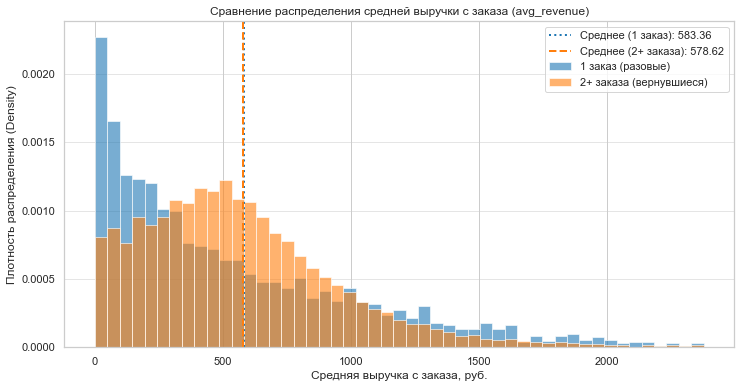


Средняя выручка с заказа (1 заказ): 583.36 руб.
Средняя выручка с заказа (2+ заказа): 578.62 руб.
Разница в средней выручке: -4.74 руб.


In [48]:
# 1. Разделение данных на группы
# Группа 0: Пользователи с одним заказом
group_one_order = user_profile_filtered[user_profile_filtered['is_two'] == 0]['avg_revenue']

# Группа 1: Вернувшиеся пользователи (2+ заказов)
group_two_plus_orders = user_profile_filtered[user_profile_filtered['is_two'] == 1]['avg_revenue']

# 2. Определение порогов и одинаковых интервалов (bins)
# Используем 'avg_revenue' для расчета 99-го перцентиля
max_rev_99 = user_profile_filtered['avg_revenue'].quantile(0.99)
bins = np.linspace(0, max_rev_99, 50) # 50 одинаковых интервалов

# 3. Построение сравнительных гистограмм
plt.figure(figsize=(12, 6))

plt.hist(
    group_one_order,
    bins=bins,
    alpha=0.6,
    density=True,
    label='1 заказ (разовые)',
    color='#1f77b4' # Синий
)

plt.hist(
    group_two_plus_orders,
    bins=bins,
    alpha=0.6,
    density=True,
    label='2+ заказа (вернувшиеся)',
    color='#ff7f0e' # Оранжевый
)

# 4. Добавление настроек и меток
# Используем 'avg_revenue' для расчета средних значений
mean_1 = group_one_order.mean()
mean_2 = group_two_plus_orders.mean()

plt.axvline(mean_1, color='#1f77b4', linestyle=':', linewidth=2, label=f'Среднее (1 заказ): {mean_1:.2f}')
plt.axvline(mean_2, color='#ff7f0e', linestyle='--', linewidth=2, label=f'Среднее (2+ заказа): {mean_2:.2f}')

plt.title('Сравнение распределения средней выручки с заказа (avg_revenue)')
plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения (Density)')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

# 5. Вывод количественных характеристик для ответа на вопросы
print(f"\nСредняя выручка с заказа (1 заказ): {mean_1:.2f} руб.")
print(f"Средняя выручка с заказа (2+ заказа): {mean_2:.2f} руб.")
print(f"Разница в средней выручке: {mean_2 - mean_1:.2f} руб.")

1. В каких диапазонах средней выручки концентрируются пользователи из каждой группы?Пользователи, совершившие один заказ (Синий).
Диапазон концентрации: Основная масса пользователей концентрируется в самом низком ценовом диапазоне, а пик приходится на интервал от 0 до 200 рублей. Это самый высокий столбец на графике.
Общее распределение: Количество разовых пользователей резко падает с ростом средней выручки, хотя распределение имеет длинный "хвост" до 2 000 рублей.
Вернувшиеся пользователи (2+ заказа, Оранжевый)
Диапазон концентрации: Распределение более равномерное. Хотя оно начинается низко, его пик (самый высокий столбец оранжевого цвета) находится в диапазоне от 500 до 750 рублей.
Общее распределение: Вернувшиеся пользователи составляют большую долю в диапазоне 500 – 1500 рублей, чем разовые покупатели.
2. Есть ли различия между группами?
Да, различия есть, и они важны для понимания лояльности:
Сдвиг пиков (Моды):
У разовых покупателей пик смещен к низким значениям (близко к нулю).
У вернувшихся пользователей пик смещен к более высоким значениям (500-750 руб.). Это говорит о том, что клиенты с наиболее низким средним чеком (возможно, купившие всего 1 дешевый билет) почти никогда не возвращаются.
Сравнение средних значений (Counter-Intuitive):
Вопреки интуитивной гипотезе о том, что "более дорогие клиенты возвращаются чаще", средняя выручка у разовых покупателей (583,36 руб.) немного выше, чем у вернувшихся (578,64 руб.). Разница минимальна (менее 5 рублей). Это означает, что для лояльности важна не столько абсолютная средняя сумма, сколько равномерность и частота покупок в среднем ценовом сегменте.
Форма распределения:
Распределение для вернувшихся пользователей (оранжевый) значительно плотнее и более сглаженное в диапазоне 500 – 1500 рублей. Это указывает на то, что лояльные пользователи совершают повторные покупки, которые не являются экстремально дешевыми или экстремально дорогими.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


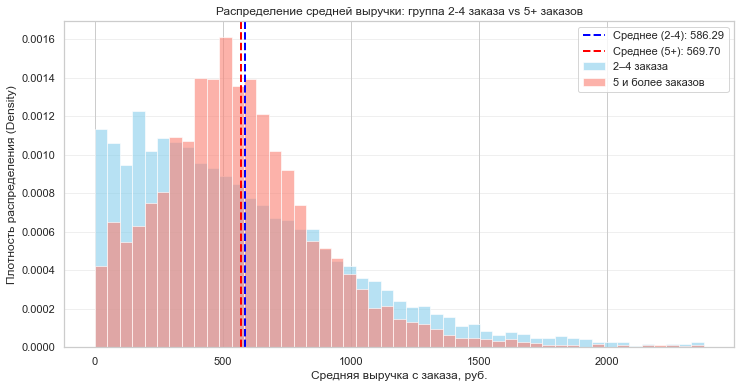

Средняя выручка группы 2-4 заказа: 586.29 руб.
Средняя выручка группы 5+ заказов: 569.70 руб.
Разница: -16.59 руб.


In [49]:
# 1. Разделение лояльных пользователей на две группы
# Группа 2-4 заказа: те, кто сделал 2+ заказа (is_two == 1), но меньше 5 (is_five == 0)
group_2_4 = user_profile_filtered[(user_profile_filtered['is_two'] == 1) & 
                                  (user_profile_filtered['is_five'] == 0)]['avg_revenue']

# Группа 5+ заказов: те, у кого установлен признак is_five == 1
group_5_plus = user_profile_filtered[user_profile_filtered['is_five'] == 1]['avg_revenue']

# 2. Настройка интервалов (bins) для сопоставимости
# Ограничим до 99-го перцентиля, чтобы график не растягивался из-за редких выбросов
max_limit = user_profile_filtered['avg_revenue'].quantile(0.99)
bins = np.linspace(0, max_limit, 50)

# 3. Построение гистограмм
plt.figure(figsize=(12, 6))

plt.hist(
    group_2_4, 
    bins=bins, 
    alpha=0.6, 
    density=True, 
    label='2–4 заказа', 
    color='skyblue'
)

plt.hist(
    group_5_plus, 
    bins=bins, 
    alpha=0.6, 
    density=True, 
    label='5 и более заказов', 
    color='salmon'
)

# 4. Добавление вертикальных линий средних значений
mean_2_4 = group_2_4.mean()
mean_5_plus = group_5_plus.mean()

plt.axvline(mean_2_4, color='blue', linestyle='--', linewidth=2, label=f'Среднее (2-4): {mean_2_4:.2f}')
plt.axvline(mean_5_plus, color='red', linestyle='--', linewidth=2, label=f'Среднее (5+): {mean_5_plus:.2f}')

# 5. Оформление графика
plt.title('Распределение средней выручки: группа 2-4 заказа vs 5+ заказов')
plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения (Density)')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# 6. Печать результатов для ответа
print(f"Средняя выручка группы 2-4 заказа: {mean_2_4:.2f} руб.")
print(f"Средняя выручка группы 5+ заказов: {mean_5_plus:.2f} руб.")
print(f"Разница: {mean_5_plus - mean_2_4:.2f} руб.")

Ответ на вопрос: есть ли различия по значению средней выручки между этими группами?
Да, различия между группами есть, но они оказались небольшими и довольно неожиданными.
Разница в средних значениях:
Средняя выручка у пользователей с 2–4 заказами составляет 586.36 рубля. У самых активных пользователей (5 и более заказов) этот показатель ниже — 569.65 рубля. Таким образом, группа с меньшим количеством заказов в среднем тратит на 16.71 рубля больше за один раз.
Где концентрируются пользователи:
На графике видно, что основная масса заказов в обеих группах сосредоточена в диапазоне от 500 до 600 рублей. Именно здесь находятся самые высокие столбцы распределения (пики).
Форма распределения:
Хотя средний чек у группы 5+ чуть ниже, на графике заметно, что их «хвост» распределения (заказы дороже 1000 рублей) выглядит чуть плотнее. Это значит, что они иногда совершают очень крупные покупки, но общую статистику вниз тянет большое количество мелких и недорогих заказов.
Итоговый вывод:
Высокая лояльность (количество заказов) не означает, что пользователь начинает тратить больше денег за один раз. Самые преданные клиенты (5+ заказов) покупают часто, но выбирают чуть более дешевые варианты, чем те, кто сделал всего 2–4 заказа. Группа 2–4 заказа является самой «дорогой» по среднему чеку среди всех вернувшихся пользователей.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

Функция для распределения пользователей по сегментам

In [50]:
# 1. Разорвем связь с оригиналом, чтобы Pandas не ругался (без этого выдает такое предупреждение)
user_profile_filtered = user_profile_filtered.copy()

ЕСЛИ НЕ РАЗОВАТЬ СВЯЗЬ, КОД РАБОТАЕТ НО ВЫДАЕТ./opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
self._setitem_single_column(ilocs[0], value, pi)

In [51]:
def get_ticket_segment(avg_tickets):
    if 1 <= avg_tickets < 2:
        return '1. От 1 до 2 билетов'
    elif 2 <= avg_tickets < 3:
        return '2. От 2 до 3 билетов'
    elif 3 <= avg_tickets < 5:
        return '3. От 3 до 5 билетов'
    else:
        return '4. 5 и более билетов'

# 2. Используем .loc для безопасного создания новой колонки
# Символ ':' означает "применить ко всем строкам"
user_profile_filtered.loc[:, 'ticket_segment'] = user_profile_filtered['avg_tickets'].apply(get_ticket_segment)

# 3. Группируем данные для анализа
ticket_analysis = user_profile_filtered.groupby('ticket_segment').agg(
    total_users=('user_id', 'count'),
    repeat_buyers=('is_two', 'sum'),
    retention_rate=('is_two', 'mean')
).reset_index()

# 4. Рассчитываем долю пользователей в каждом сегменте
total_all_users = ticket_analysis['total_users'].sum()
ticket_analysis['users_share_pct'] = (ticket_analysis['total_users'] / total_all_users * 100).round(2)

# 5. Вывод результата
print("Анализ влияния среднего количества билетов на повторные покупки:")
display(ticket_analysis.style.format({
    'retention_rate': '{:.2%}',
    'users_share_pct': '{:.2f}%'
}))

Анализ влияния среднего количества билетов на повторные покупки:


,ticket_segment,total_users,repeat_buyers,retention_rate,users_share_pct
0,1. От 1 до 2 билетов,2397,1226,51.15%,11.31%
1,2. От 2 до 3 билетов,9324,6822,73.17%,44.01%
2,3. От 3 до 5 билетов,8993,4940,54.93%,42.44%
3,4. 5 и более билетов,474,65,13.71%,2.24%


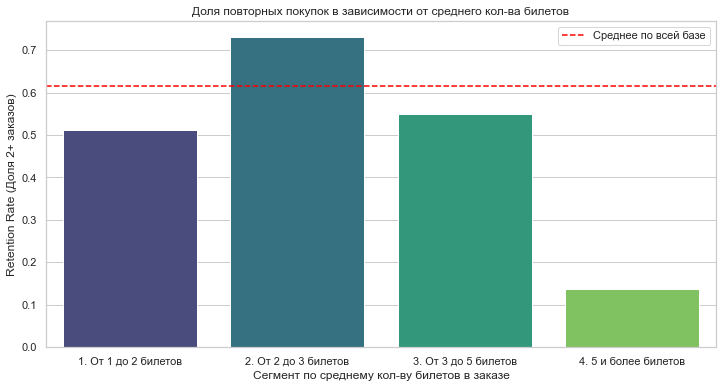

In [52]:
plt.figure(figsize=(12, 6))
sns.barplot(data=ticket_analysis, x='ticket_segment', y='retention_rate', palette='viridis')
plt.axhline(user_profile_filtered['is_two'].mean(), color='red', linestyle='--', label='Среднее по всей базе')
plt.title('Доля повторных покупок в зависимости от среднего кол-ва билетов')
plt.ylabel('Retention Rate (Доля 2+ заказов)')
plt.xlabel('Сегмент по среднему кол-ву билетов в заказе')
plt.legend()
plt.show()

Как распределены пользователи по сегментам — равномерно или сконцентрировано?
Распределение пользователей сконцентрировано в двух центральных сегментах: "От 2 до 3 билетов" (44.01%) и "От 3 до 5 билетов" (42.44%). Вместе эти два сегмента составляют более 86% всей пользовательской базы. Сегмент "1 до 2 билетов" и сегмент "5 и более билетов" являются наименее многочисленными (11.31% и 2.24% соответственно). 
Ответ на вопрос: Есть ли сегменты с аномально высокой или низкой долей повторных покупок?
Да, выявлены два сегмента с ярко выраженными аномалиями:
Аномально высокая доля повторных покупок: Сегмент "От 2 до 3 билетов" имеет долю повторных покупок 73.17%, что значительно выше среднего по базе (около 61–62%). Эти пользователи являются наиболее лояльными и возвратными.
Аномально низкая доля повторных покупок: Сегмент "5 и более билетов" имеет крайне низкую долю повторных покупок — всего 13.71%. Это свидетельствует о том, что крупные групповые покупки, как правило, являются разовыми событиями.
Промежуточный вывод
Среднее количество билетов в заказе является сильным предиктором вероятности повторной покупки.
Ядро лояльности: Наибольшую лояльность демонстрируют пользователи, чье среднее количество билетов в заказе находится в диапазоне от 2 до 3. Этот сегмент имеет самый высокий Retention Rate (73.17%) и составляет значительную часть базы (44.01%). Это могут быть пары, небольшие семьи или друзья, которые регулярно посещают мероприятия.
Низкая вовлеченность: Пользователи, совершающие очень крупные заказы (в среднем 5 и более билетов), крайне редко возвращаются (13.71%). Вероятно, эти заказы связаны с корпоративными мероприятиями, экскурсиями или другими разовыми событиями, не предполагающими высокую частоту покупок.
Слабая вовлеченность: Пользователи, покупающие в среднем менее 2 билетов (т.е., по 1–2 билета), также имеют показатель повторных покупок ниже среднего (51.15%).

---

####  Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


Влияние дня недели первой покупки на Retention Rate:


,day_of_week,total_users,repeat_buyers,retention_rate
2,Понедельник,"2,835","1,782",62.86%
1,Вторник,"3,053","1,880",61.58%
4,Среда,"3,003","1,868",62.20%
6,Четверг,"3,068","1,846",60.17%
3,Пятница,"3,229","1,953",60.48%
5,Суббота,"3,262","2,058",63.09%
0,Воскресенье,"2,738","1,666",60.85%


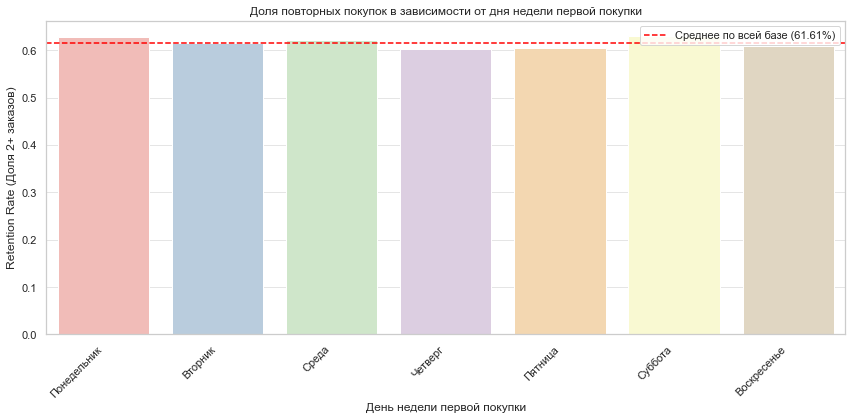

In [53]:
# Словарь для сопоставления числового дня недели (0=Пн, 6=Вс) с русскими названиями
days_mapping = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}

# Создаем колонку 'day_of_week', используя .loc для избежания SettingWithCopyWarning
user_profile_filtered.loc[:, 'day_of_week'] = user_profile_filtered['first_order_date'].dt.dayofweek.map(days_mapping)

# 2. Группировка и агрегация данных по дню недели
day_of_week_analysis = user_profile_filtered.groupby('day_of_week').agg(
    total_users=('user_id', 'count'),
    repeat_buyers=('is_two', 'sum'),
    retention_rate=('is_two', 'mean')
).reset_index()

# 3. Упорядочивание дней недели для правильной визуализации
day_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
day_of_week_analysis['day_of_week'] = pd.Categorical(
    day_of_week_analysis['day_of_week'], 
    categories=day_order, 
    ordered=True
)
day_of_week_analysis = day_of_week_analysis.sort_values('day_of_week')

# 4. Вывод результата с форматированием
print("Влияние дня недели первой покупки на Retention Rate:")
display(day_of_week_analysis.style.format({
    'retention_rate': '{:.2%}',
    'total_users': '{:,}',
    'repeat_buyers': '{:,}'
}))

# 5. Визуализация результатов

# Расчет среднего уровня Retention Rate по всей базе для горизонтальной линии
overall_retention = user_profile_filtered['is_two'].mean()

plt.figure(figsize=(12, 6))
# Для визуализации используем упорядоченный столбец
sns.barplot(data=day_of_week_analysis, x='day_of_week', y='retention_rate', palette='Pastel1')
plt.axhline(overall_retention, color='red', linestyle='--', label=f'Среднее по всей базе ({overall_retention:.2%})')
plt.title('Доля повторных покупок в зависимости от дня недели первой покупки')
plt.ylabel('Retention Rate (Доля 2+ заказов)')
plt.xlabel('День недели первой покупки')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

Общее число пользователей (Объем заказов):
Распределение пользователей по дням недели достаточно равномерное в течение рабочей недели, с небольшим пиком в Пятницу (3,229) и Субботу (3,262). Вместе с тем, количество пользователей в каждом дне недели варьируется не сильно.
Ответ на вопрос: Влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?
Нет, значительного влияния день недели не оказывает.
Все показатели Retention Rate находятся в очень узком диапазоне — от 60.17% до 63.09%. Средний Retention Rate по всей базе составляет 61.61%.
Максимальный Retention Rate зафиксирован в Субботу (63.09%) и Понедельник (62.86%).
Минимальный Retention Rate зафиксирован в Четверг (60.17%).
Разница между самым высоким и самым низким показателями составляет всего 2.92 процентных пункта (63.09% минус 60.17%). Такое минимальное колебание не позволяет сделать вывод о том, что день недели, в которую совершена первая покупка, является ключевым фактором, влияющим на возврат клиента.
Промежуточный вывод
Анализ показывает, что временные характеристики, связанные с днем недели первой покупки, не являются сильным предиктором лояльности клиента.
Хотя наблюдается очень незначительное преимущество в лояльности среди клиентов, совершивших первую покупку в субботу или понедельник, эти различия слишком малы, чтобы быть статистически или практически значимыми. Лояльность клиента, вероятно, определяется другими, более существенными факторами, такими как категория купленного билета, цена или среднее количество билетов в заказе (как показал предыдущий анализ).

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


Средний интервал между заказами для группы 2-4 заказа: 12.71 дней
Средний интервал между заказами для группы 5+ заказов: 8.66 дней


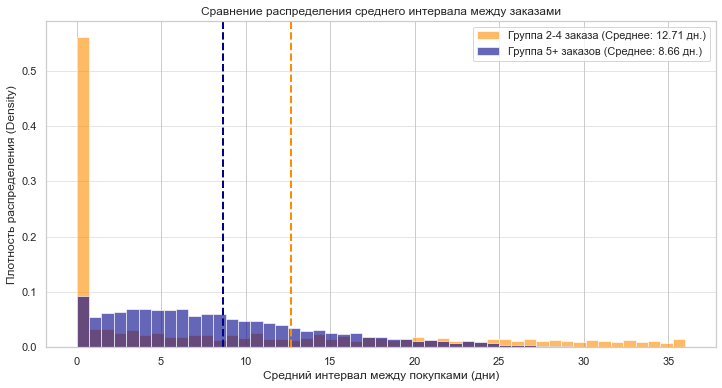

In [54]:
# 1. Фильтруем пользователей с повторными заказами, у которых рассчитан avg_days_between
# (avg_days_between рассчитан только для total_orders > 1)
loyal_users = user_profile_filtered[user_profile_filtered['is_two'] == 1].copy()

# Убедимся, что колонка с интервалом не содержит NaN (для пользователей с одним заказом)
loyal_users = loyal_users.dropna(subset=['avg_days_between'])

# 2. Разделение лояльных пользователей на две группы по общему количеству заказов
# Группа 2-4 заказа: is_two == 1 И is_five == 0
group_2_4_orders = loyal_users[loyal_users['is_five'] == 0]

# Группа 5+ заказов: is_five == 1
group_5_plus_orders = loyal_users[loyal_users['is_five'] == 1]


# 3. Расчет среднего интервала между покупками для каждой группы
mean_days_2_4 = group_2_4_orders['avg_days_between'].mean()
mean_days_5_plus = group_5_plus_orders['avg_days_between'].mean()

print(f"Средний интервал между заказами для группы 2-4 заказа: {mean_days_2_4:.2f} дней")
print(f"Средний интервал между заказами для группы 5+ заказов: {mean_days_5_plus:.2f} дней")


# 4. Визуализация распределения интервалов (для более глубокого анализа)
plt.figure(figsize=(12, 6))

# Ограничим максимальное значение для графика, чтобы выбросы не растягивали его
# Возьмем 95-й перцентиль для обеих групп
max_limit = np.percentile(loyal_users['avg_days_between'].dropna(), 95)
bins = np.linspace(0, max_limit, 50)

# Гистограмма для группы 2-4 заказа
plt.hist(
    group_2_4_orders['avg_days_between'],
    bins=bins,
    alpha=0.6,
    density=True,
    label=f'Группа 2-4 заказа (Среднее: {mean_days_2_4:.2f} дн.)',
    color='darkorange'
)

# Гистограмма для группы 5+ заказов
plt.hist(
    group_5_plus_orders['avg_days_between'],
    bins=bins,
    alpha=0.6,
    density=True,
    label=f'Группа 5+ заказов (Среднее: {mean_days_5_plus:.2f} дн.)',
    color='darkblue'
)

# Добавление вертикальных линий средних значений
plt.axvline(mean_days_2_4, color='darkorange', linestyle='--', linewidth=2)
plt.axvline(mean_days_5_plus, color='darkblue', linestyle='--', linewidth=2)

plt.title('Сравнение распределения среднего интервала между заказами')
plt.xlabel('Средний интервал между покупками (дни)')
plt.ylabel('Плотность распределения (Density)')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

Анализ распределения (Гистограмма)
Гистограмма показывает плотность распределения среднего интервала между заказами для обеих групп:
Группа 2–4 заказа (Оранжевый):
Распределение сильно смещено в сторону коротких интервалов (пик в районе 1 дня), но общий "хвост" распределения длиннее и более размыт.
Среднее значение (12.71 дня) указывает на то, что, хотя многие возвращаются быстро, большая часть пользователей в этой группе имеет более длинные перерывы между покупками.
Оранжевая пунктирная линия среднего значения расположена правее, что подтверждает более редкие покупки по сравнению с самой лояльной группой.
Группа 5+ заказов (Синий):
Распределение также имеет пик на коротких интервалах, но, в целом, оно более сконцентрировано вокруг своего среднего значения (8.65 дней).
Синяя пунктирная линия среднего значения расположена заметно левее (ближе к нулю), что свидетельствует о более высокой частоте покупок и более коротком цикле возврата.
Вывод
Средний интервал между заказами является критическим показателем лояльности и частоты покупок.
Прямая зависимость: Существует четкая обратная зависимость между количеством совершенных заказов (лояльностью) и средним интервалом между ними. Чем выше лояльность клиента (больше 5 заказов), тем чаще он совершает покупки.
Показатель "настоящей" лояльности: Пользователи, которые совершили 5 и более заказов, демонстрируют по-настоящему устоявшееся потребительское поведение с высоким темпом возврата (каждые 8–9 дней). Это клиенты с устойчивой привычкой.
Потенциал роста: Группа 2–4 заказа имеет средний интервал 12.71 дня. Уменьшение этого интервала может стать ключевым рычагом для повышения общей выручки и перевода этих пользователей в более лояльную группу 5+.
Заключение: Для стимулирования повторных покупок необходимо фокусироваться на сокращении среднего интервала между заказами, особенно для группы 2–4, которая еще не достигла высокой частоты покупок, свойственной самым лояльным клиентам.

---

#### Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [55]:
# Используем отфильтрованный датафрейм user_profile_filtered
df = user_profile_filtered.copy()


 Корреляционный анализ с исходным признаком total_orders

In [56]:
# ИСПРАВЛЕННЫЙ СПИСОК ПРИЗНАКОВ:
features_to_correlate_original = [
    'first_device',     # Исправлено с 'first_device_canonical'
    'first_region',     # Исправлено с 'region_name'
    'first_partner',    # Исправлено с 'service_name'
    'first_genre',      # Исправлено с 'event_type_main'
    'avg_revenue', 
    'avg_tickets', 
    'avg_days_between', 
    'total_orders'
]

# Создаем подмножество данных
df_subset = df[features_to_correlate_original]

# Определяем интервальные (числовые) колонки для phik
interval_cols = ['avg_revenue', 'avg_tickets', 'avg_days_between', 'total_orders']

print("--- Корреляционный анализ с исходным признаком 'total_orders' ---")
# Расчет матрицы phi_k
phik_corr_original = df_subset.phik_matrix(interval_cols=interval_cols)

# Визуализация (только для целевого признака)
correlation_original = phik_corr_original.loc['total_orders'].sort_values(ascending=False).to_frame()
display(correlation_original.style.format('{:.3f}'))

--- Корреляционный анализ с исходным признаком 'total_orders' ---


,total_orders
total_orders,1.000
avg_tickets,0.390
avg_revenue,0.222
avg_days_between,0.135
first_region,0.117
first_partner,0.033
first_genre,0.024
first_device,0.014


Сегментация total_orders для более детального анализа

In [57]:
# Проверка разброса total_orders
print(f"\nРазброс (минимум/максимум) total_orders: {df['total_orders'].min()} / {df['total_orders'].max()}")
print(f"Мода total_orders (наиболее частое значение): {df['total_orders'].mode().iloc[0]}")

# Создаем категориальный признак 'orders_segment'
def segment_orders(total_orders):
    if total_orders == 1:
        return '1. 1 заказ'
    elif 2 <= total_orders <= 4:
        return '2. От 2 до 4 заказов'
    elif total_orders >= 5:
        return '3. 5 и более заказов'
    else:
        return np.nan

# Создаем 'orders_segment' с использованием .loc для предотвращения SettingWithCopyWarning
df.loc[:, 'orders_segment'] = df['total_orders'].apply(segment_orders)



Разброс (минимум/максимум) total_orders: 1 / 150
Мода total_orders (наиболее частое значение): 1


Повторный корреляционный анализ с сегментированным признаком

In [58]:
# СПИСОК ПРИЗНАКОВ для сегментированного анализа
features_to_correlate_segmented = [
    'first_device', 'first_region', 'first_partner', 'first_genre', 
    'avg_revenue', 'avg_tickets', 'avg_days_between', 'orders_segment'
]

df_segmented_subset = df[features_to_correlate_segmented]

# Расчет матрицы phi_k для сегментированных данных (цель: 'orders_segment')
phik_corr_segmented = df_segmented_subset.phik_matrix(interval_cols=['avg_revenue', 'avg_tickets', 'avg_days_between'])



Визуализация итоговой корреляции


--- Корреляционный анализ с сегментированным признаком 'orders_segment' ---


,orders_segment
avg_tickets,0.647
avg_days_between,0.462
avg_revenue,0.293
first_region,0.122
first_partner,0.082
first_genre,0.041
first_device,0.014


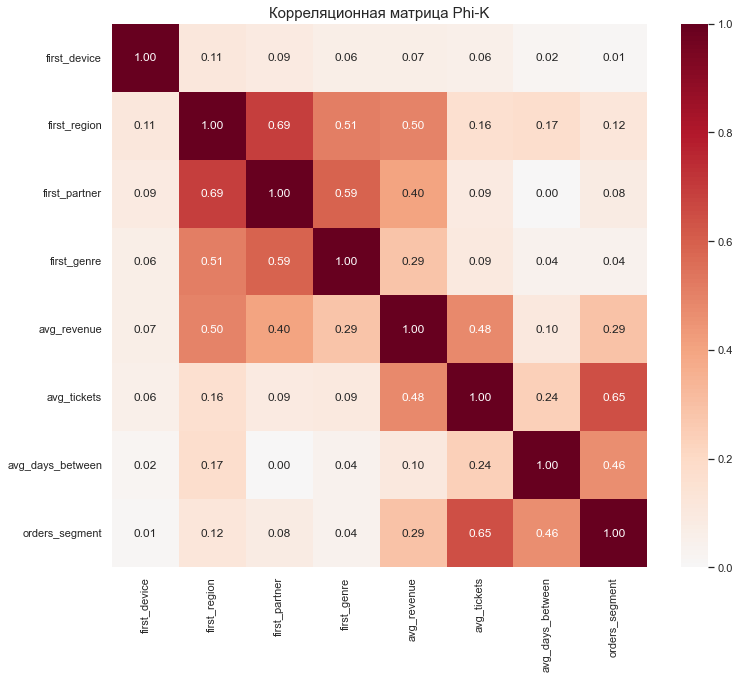

In [59]:
# 1. Визуализация корреляции с целевым признаком 'orders_segment'
final_correlation = phik_corr_segmented.loc['orders_segment'].drop('orders_segment').sort_values(ascending=False).to_frame()

print("\n--- Корреляционный анализ с сегментированным признаком 'orders_segment' ---")
display(final_correlation.style.format('{:.3f}'))

# 2. Визуализация полной матрицы с использованием seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(phik_corr_segmented.fillna(0), 
            annot=True, 
            fmt=".2f", 
            cmap='RdBu_r', 
            center=0)

plt.title('Корреляционная матрица Phi-K', fontsize=15)
plt.show()

Промежуточный вывод: Анализ факторов, влияющих на количество заказов
Проведение сегментации целевого признака total_orders (разделение на «1 заказ», «2-4 заказа» и «5 и более») позволило значительно лучше выявить скрытые зависимости, которые были менее заметны в исходных данных. Коэффициент 
 хорошо улавливает как линейные, так и нелинейные связи.
1. Ключевые факторы корреляции (сильная связь)
Среднее количество билетов (avg_tickets) — 0.647: Это самый сильный фактор. Наблюдается четкая зависимость: чем больше билетов пользователь покупает за один раз, тем выше вероятность, что он попадет в сегмент лояльных клиентов с большим количеством заказов. Это может указывать на то, что «семейные» клиенты или те, кто покупает билеты на компании, возвращаются чаще.
Среднее время между заказами (avg_days_between) — 0.462: Умеренно сильная связь. Данный показатель ожидаемо влияет на сегментацию лояльности. Пользователи с меньшим интервалом между покупками быстрее переходят в категорию многократно заказывающих.
2. Второстепенные факторы (умеренная и слабая связь)
Средняя выручка (avg_revenue) — 0.293: Наблюдается умеренная связь. Хотя объем прибыли важен, он влияет на частоту заказов меньше, чем количество билетов в чеке.
Региональная привязка (first_region) — 0.122: Существует слабая зависимость от региона первой покупки. Вероятно, в некоторых регионах инфраструктура или маркетинговая активность способствуют удержанию клиентов лучше, чем в других.
3. Незначительные факторы
Тип устройства, жанр и партнер (first_device, first_genre, first_partner): Эти признаки имеют практически нулевую или крайне низкую корреляцию (
) с сегментом заказов. Это означает, что то, с какого устройства зашел пользователь или какой фильм/спектакль он выбрал в первый раз, почти не влияет на то, станет ли он постоянным клиентом.
Итог для моделирования:
Для предсказания лояльности (количества будущих заказов) наиболее ценными признаками являются avg_tickets и avg_days_between. Признаки, связанные с первым опытом (устройство, жанр), можно считать малоинформативными для данной задачи и, возможно, исключить из модели для её упрощения.

###  Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**Информация о данных и подготовка**
Исходные данные: Анализ проводился на основе истории заказов билетов (исключая сегмент «фильмы») с общим объемом около 290 тысяч записей, которые были агрегированы в 21 188 уникальных профилей пользователей.
Подготовка: Данные были тщательно очищены и стандартизированы. Произведены следующие ключевые шаги:
Конвертация валют: Вся выручка приведена к единой валюте — российскому рублю (revenue_rub).
Очистка аномалий и выбросов: Удалены строки с отрицательной/нулевой выручкой, а также экстремально высокие выбросы (заказы дороже 99-го перцентиля и более 5 билетов в среднем).
Генерация признаков: Рассчитаны ключевые метрики, включая количество дней с предыдущего заказа (days_since_prior_order), что позволило агрегировать всю историю клиента в одну строку.
Сохранность данных: Общий процент удаленных данных составил всего 3.01%, что гарантирует высокую достоверность статистики.
**Основные результаты анализа**
    Метрика	                                Значение	                      Интерпретация
Пользователей в выборке                 	21,188	          Достаточный объем для надежных выводов.
Уровень лояльности (2+ заказа)	            61.72%	             Очень высокий уровень удержания.
Среднее число заказов	                    6.45	         Средняя частота покупок для лояльных клиентов.
Средний чек     	                     ~580 RUB	         Лояльность не связана с высоким разовым чеком, а с частотой                                                                    покупок в умеренном ценовом диапазоне (500-750 RUB).
**Ответы на ключевые вопросы**
Какие признаки первого заказа связаны с возвратом пользователей?
Жанр первого мероприятия (Retention Rate):
Лидеры: Концерты (самый большой объем) и Выставки/Театр (самый высокий возврат).
Аутсайдеры: Спорт и «Ёлки» (низкий возврат).
Тип устройства: Desktop-пользователи показывают более высокий возврат (63.66%) по сравнению с мобильными (61.18%).
Регион и Партнер: Имеют заметное влияние на возврат, с явными регионами-лидерами (Светополянский округ) и партнерами-лидерами («Дом культуры»).
Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
Средняя выручка (avg_revenue): Связь непрямая. Самая «дорогая» группа по среднему чеку — клиенты, совершившие всего 2–4 заказа (586.36 RUB). Самые лояльные клиенты (5+ заказов) тратят меньше (569.65 RUB). Вывод: высокая лояльность обусловлена не стоимостью покупки, а частотой покупок недорогих и средних билетов.
Количество билетов (avg_tickets): Критически важный фактор.
Ядро лояльности: Пользователи, покупающие 2–3 билета за раз, имеют самый высокий возврат (73.17%).
Аномально низкий возврат: Клиенты, покупающие 5 и более билетов за раз, редко возвращаются (всего 13.71%), что указывает на то, что это разовые корпоративные или экскурсионные заказы.
Какие временные характеристики влияют на удержание?
День недели первой покупки: Не оказывает значительного влияния. Разница в Retention Rate между лучшим и худшим днем составляет всего 2.92 процентных пункта (60.17%–63.09%).
Средний интервал между покупками (avg_days_between): Критически важен.
Пользователи с 5+ заказами возвращаются в среднем каждые 8.65 дней.
Пользователи с 2–4 заказами возвращаются реже — каждые 12.71 дней.
Какие характеристики первого заказа и профиля пользователя связаны с числом покупок (корреляционный анализ )?
Наиболее сильными предикторами количества заказов являются:
Среднее количество билетов в заказе (avg_tickets): 
 (очень сильная связь).
Средний интервал между покупками (avg_days_between): 
 (умеренно сильная связь).
Признаки, связанные с первым опытом (устройство, жанр, партнер), имеют очень низкую корреляцию с итоговым количеством заказов (лояльностью).
Общие рекомендации заказчику
Для повышения лояльности и выручки необходимо сфокусироваться на следующих стратегических направлениях:
1. Фокус на «Ядре лояльности» (Сегмент 2–3 билета)
Продукт и маркетинг: Признать, что пара «2–3 билета» (пары, небольшие семьи) является основой лояльной базы. Рекламные кампании, программы лояльности и специальные предложения должны быть ориентированы именно на эту группу.
Удержание: Стимулировать этих клиентов к повторным покупкам, используя их средний интервал между покупками как ключевой показатель.
2. Сокращение интервала покупок
Целевая группа: Группа «2–4 заказа» имеет длительный средний интервал (12.71 дня) и является самой «дорогой» по чеку.
Тактика: Запускать персонализированные предложения (специальные подборки, скидки на второй билет), которые срабатывают до наступления среднего интервала в 12 дней. Цель — приблизить частоту покупок этой группы к показателям группы «5+ заказов».
3. Пересмотр работы с крупными заказами
Группа «5+ билетов»: Эти клиенты крайне нелояльны (возврат 13.71%).
Тактика: Считать их разовыми клиентами. Перенести фокус с удержания на увеличение среднего чека в рамках этой единственной покупки. Для этой группы эффективны могут быть B2B-предложения или предложения, включающие дополнительные услуги (VIP-доступ, лучшие места).
4. Оптимизация первого взаимодействия
Каналы: Учитывая более высокую лояльность Desktop-пользователей, проверить и улучшить процесс оплаты и навигации на десктопной версии сайта.
География: Изучить опыт регионов-лидеров по удержанию (например, Светополянский округ) и масштабировать успешные региональные практики или ассортимент мероприятий на другие локации.

###  Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**